<a href="https://colab.research.google.com/github/Lursen/DCGAN-for-portrait-generation/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка обучающих данных

In [3]:
import os
import gdown
from zipfile import ZipFile

os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Инициализация генератора данных

In [5]:
import tensorflow as tf
from tensorflow import keras

dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


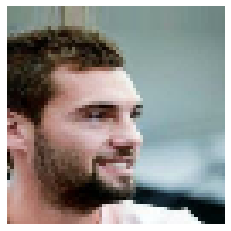

In [8]:
import numpy as np
import matplotlib.pyplot as plt

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Аугментация обучающих данных

In [ ]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.005),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

dataset = dataset.map(lambda x: (data_augmentation(x, training=True)))


Инициализация архитектуры GAN (генератора и дискриминатора)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import ReLU


discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Создание класса GANа

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def load_model(self):
        self.generator.load_weights('/content/drive/MyDrive/Colab_Notebooks/GAN_Portraits/model_weights/dcgen_w')
        self.discriminator.load_weights('/content/drive/MyDrive/Colab_Notebooks/GAN_Portraits/model_weights/dcdis_w')

    def get_image(self):
        random_latent_vectors = tf.random.normal(shape=(5, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        for i in range(5):
          img = keras.preprocessing.image.array_to_img(generated_images[i])
          plt.figure()
          plt.imshow(img)

    def print_imgs(self):
        r, c = 3, 3
        noise = tf.random.normal(shape=(r*c, self.latent_dim))
        gen_imgs = self.generator(noise)

        f, axarr = plt.subplots(r,c)
        for i in range(r):
          for j in range(c):
            axarr[i,j].imshow(keras.preprocessing.image.array_to_img(gen_imgs[i*j]))

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Создание шума для генератора
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Создание фальшивых изображений
        generated_images = self.generator(random_latent_vectors)
        # Объединение фальшивых и настоящих изображений
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Получение меток для отличия фальшивых и настоящих изображений
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум к меткам
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Обучение дискриминатора
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Создание шума для генератора
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Создание фальшивых меток
        misleading_labels = tf.zeros((batch_size, 1))

        # Обучение генератора
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Обновление метрик
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        self.force_save_weights()
        random_latent_vectors = tf.random.normal(shape=(self.num_img*self.num_img, self.latent_dim))
        gen_imgs = self.model.generator(random_latent_vectors)

        r, c = self.num_img, self.num_img
        f, axarr = plt.subplots(r,c)
        for i in range(r):
          for j in range(c):
            axarr[i,j].imshow(keras.preprocessing.image.array_to_img(gen_imgs[i*j]))
            

    def force_save_weights(self):
        self.model.generator.save_weights('/content/drive/MyDrive/Colab_Notebooks/GAN_Portraits/model_weights/dcgen_w')
        self.model.discriminator.save_weights('/content/drive/MyDrive/Colab_Notebooks/GAN_Portraits/model_weights/dcdis_w')



In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
epochs = 100  


gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)


In [ ]:
gan.load_model()

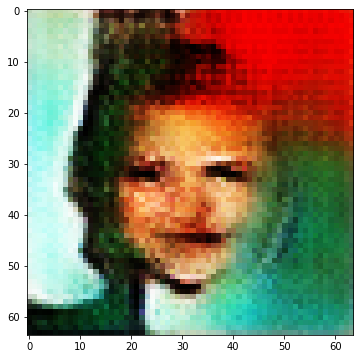

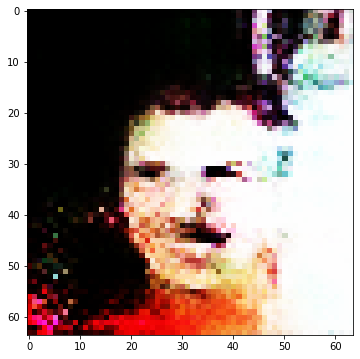

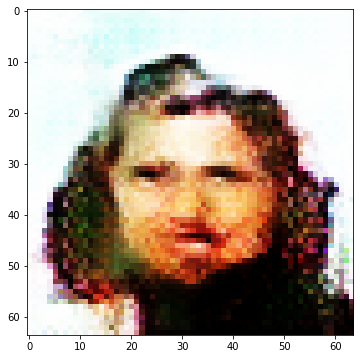

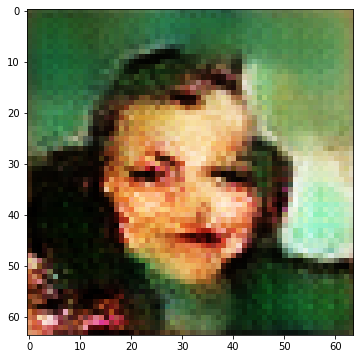

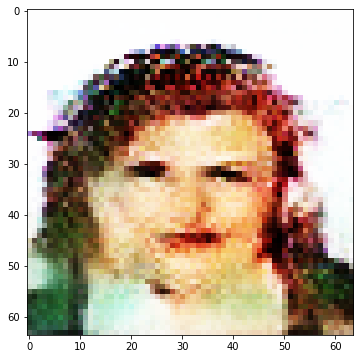

In [ ]:
img = gan.get_image()

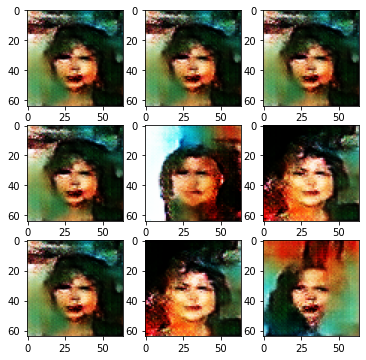

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)

gan.print_imgs()